In [110]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import healpy as hp
import matplotlib.pyplot as plt
from IPython.display import clear_output
# paralelizacion
from scipy.stats import norm
from scipy.optimize import minimize


rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 400
rcParams["font.size"] = 18

# Important parameters

#### **pts** is related to the number of points in the grid or resolution of the grid (don't change it)

#### **q0f** & **h0f** are fiducial values for LCDM

#### **repetitions** is the number of times hem_comp will be run (for testinf purposesm try for 5 repetitions)


In [111]:
pts = hp.nside2npix(4)  # Resolution for Nside = 16
h0f = 0.678  # fiducial value of h0 for planck
q0f = -0.574
# h0f = 0.7304  # fiducial value of h0 for pantheon+
zup = 0.1  # upper limit of the redshift range
zdown = 0.0
# zdown = 0.008  # lower limit of the redshift range0
repetitions = 500
prefix_name = '[SH0ES_CALIB][HEALPIX]'  # This is for file naming purposes

In [112]:
loc_lcparam = 'datos/Pantheon+SH0ES.dat.txt'
loc_lcparam_sys = 'datos/Pantheon+SH0ES_STAT+SYS.cov.txt'

In [113]:
lcparam = np.loadtxt(loc_lcparam, skiprows=1,
                     usecols=(2, 8, 9, 10, 11, 26, 27, 12, 13))
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows=1)

ind = np.where((lcparam[:, 0] < zup) & (lcparam[:, 0] > zdown))[0]

zz = lcparam[ind, 0]  # zhd
mz = lcparam[ind, 1]  # mb_corr
sigmz = lcparam[ind, 2]  # m_b_corr_err_DIAG
muz = lcparam[ind, 3]  # MU_SH0ES
sigmuz = lcparam[ind, 4]  # MU_SH0ES_ERR_DIAG
ra = lcparam[ind, 5]
dec = lcparam[ind, 6]
muceph = lcparam[ind, 7]
hostyn = lcparam[ind, 8]

hostyn_ind = np.where(hostyn == 1)[0]

cov_z = lcparam_sys.reshape(1701, 1701)
# Select only the cov matrix elements within the range.
cov_z = cov_z[np.ix_(ind, ind)]
inv_cov_z = np.linalg.inv(cov_z)

print("We have", len(zz), f"SNe with  {zdown} < z < {zup}")
print("\nCov matrix shape:", cov_z.shape)

cov_mat = pd.DataFrame(cov_z, columns=range(len(zz)))

We have 741 SNe with  0.0 < z < 0.1

Cov matrix shape: (741, 741)


In [114]:
# Cosmology model are defined in the file cosmology.py
from cosmology import mu

### Saving data into r1 array and positions (x,y,z) into v1 array


In [115]:
# Define some global variables

# Data array
r1 = np.column_stack([ra, dec, zz, mz, sigmz, muz, sigmuz, muceph, hostyn])

# Each SNe position in cartesian coordinates
v1 = np.column_stack(
    [np.sin(ra)*np.cos(dec), np.sin(ra)*np.sin(dec), np.cos(ra)])

### Loop principal del método Hemispheric Comparison for fixed q0


### Parallelization of the principal loop using Pool from multiprocessing


In [118]:
# The function get_healpix_vectors is defined in healpix_vectors.py and it returns the symmetry axes for each pixel defined by HEALPIX

from healpix_vectors import get_healpix_vectors

nside = 4  # Resolution

healpix_dirs = get_healpix_vectors(nside)

In [119]:
import hem_comp_functions


# We obtain the map by running hem_comp_functions.exec_map. This function runs the hemispheric comparison functions for each pixel to form a complete map.


results_h0, results_q0 = hem_comp_functions.exec_map(
    healpix_dirs, v1, r1, hostyn, cov_mat, h0f, q0f)

h0u, h0d, h0u_err, h0d_err = results_h0
q0u, q0d, q0u_err, q0d_err = results_q0

100%|██████████| 96/96 [00:00<00:00, 873434.24it/s]


In [120]:
# Store up and down hemisphere position vectors for plotting purposes.

hdiru = np.array(healpix_dirs)
hdird = -np.array(healpix_dirs)

# save the directions into one array with the form [hdiru,hdird]
hdirs = np.concatenate((hdiru, hdird))

h0 = np.concatenate((h0u, h0d))
h0_err = np.concatenate((h0u_err, h0d_err))
q0 = np.concatenate((q0u, q0d))
q0_err = np.concatenate((q0u_err, q0d_err))

# convert the directions of axes into spherical coordinates
theta = np.arccos(hdirs[:, 2])
phi = np.radians(90) - np.arctan2(hdirs[:, 1], hdirs[:, 0])

Calculate error for $\Delta q0$ and $\Delta h0$


In [121]:
# Calculate the error for the maximum anisotropy

h0_max_err = h0_err[np.argmax(h0)]
h0_min_err = h0_err[np.argmin(h0)]

q0_max_err = q0_err[np.argmax(q0)]
q0_min_err = q0_err[np.argmin(q0)]


delta_h0_data_err = np.sqrt(h0_max_err**2 + h0_min_err**2)
delta_q0_data_err = np.sqrt(q0_max_err**2 + q0_min_err**2)

In [122]:
# Calculate max anisotroy for each parameter

delta_h0_data_max = np.max(h0) - np.min(h0)
delta_q0_data_max = np.max(q0) - np.min(q0)

In [123]:
# print max anisotropy with respective error

print("delta_h0 = ", delta_h0_data_max, "+/-", delta_h0_data_err)
print("delta_q0 = ", delta_q0_data_max, "+/-", delta_q0_data_err)

delta_h0 =  0.011703813381917616 +/- 0.0034170781577631034
delta_q0 =  1.0650464389237047 +/- 0.2292645059862212


# Making q0 and h0 maps using HEALpy


In [124]:
rcParams["savefig.dpi"] = 400
rcParams["figure.dpi"] = 400
rcParams["font.size"] = 12

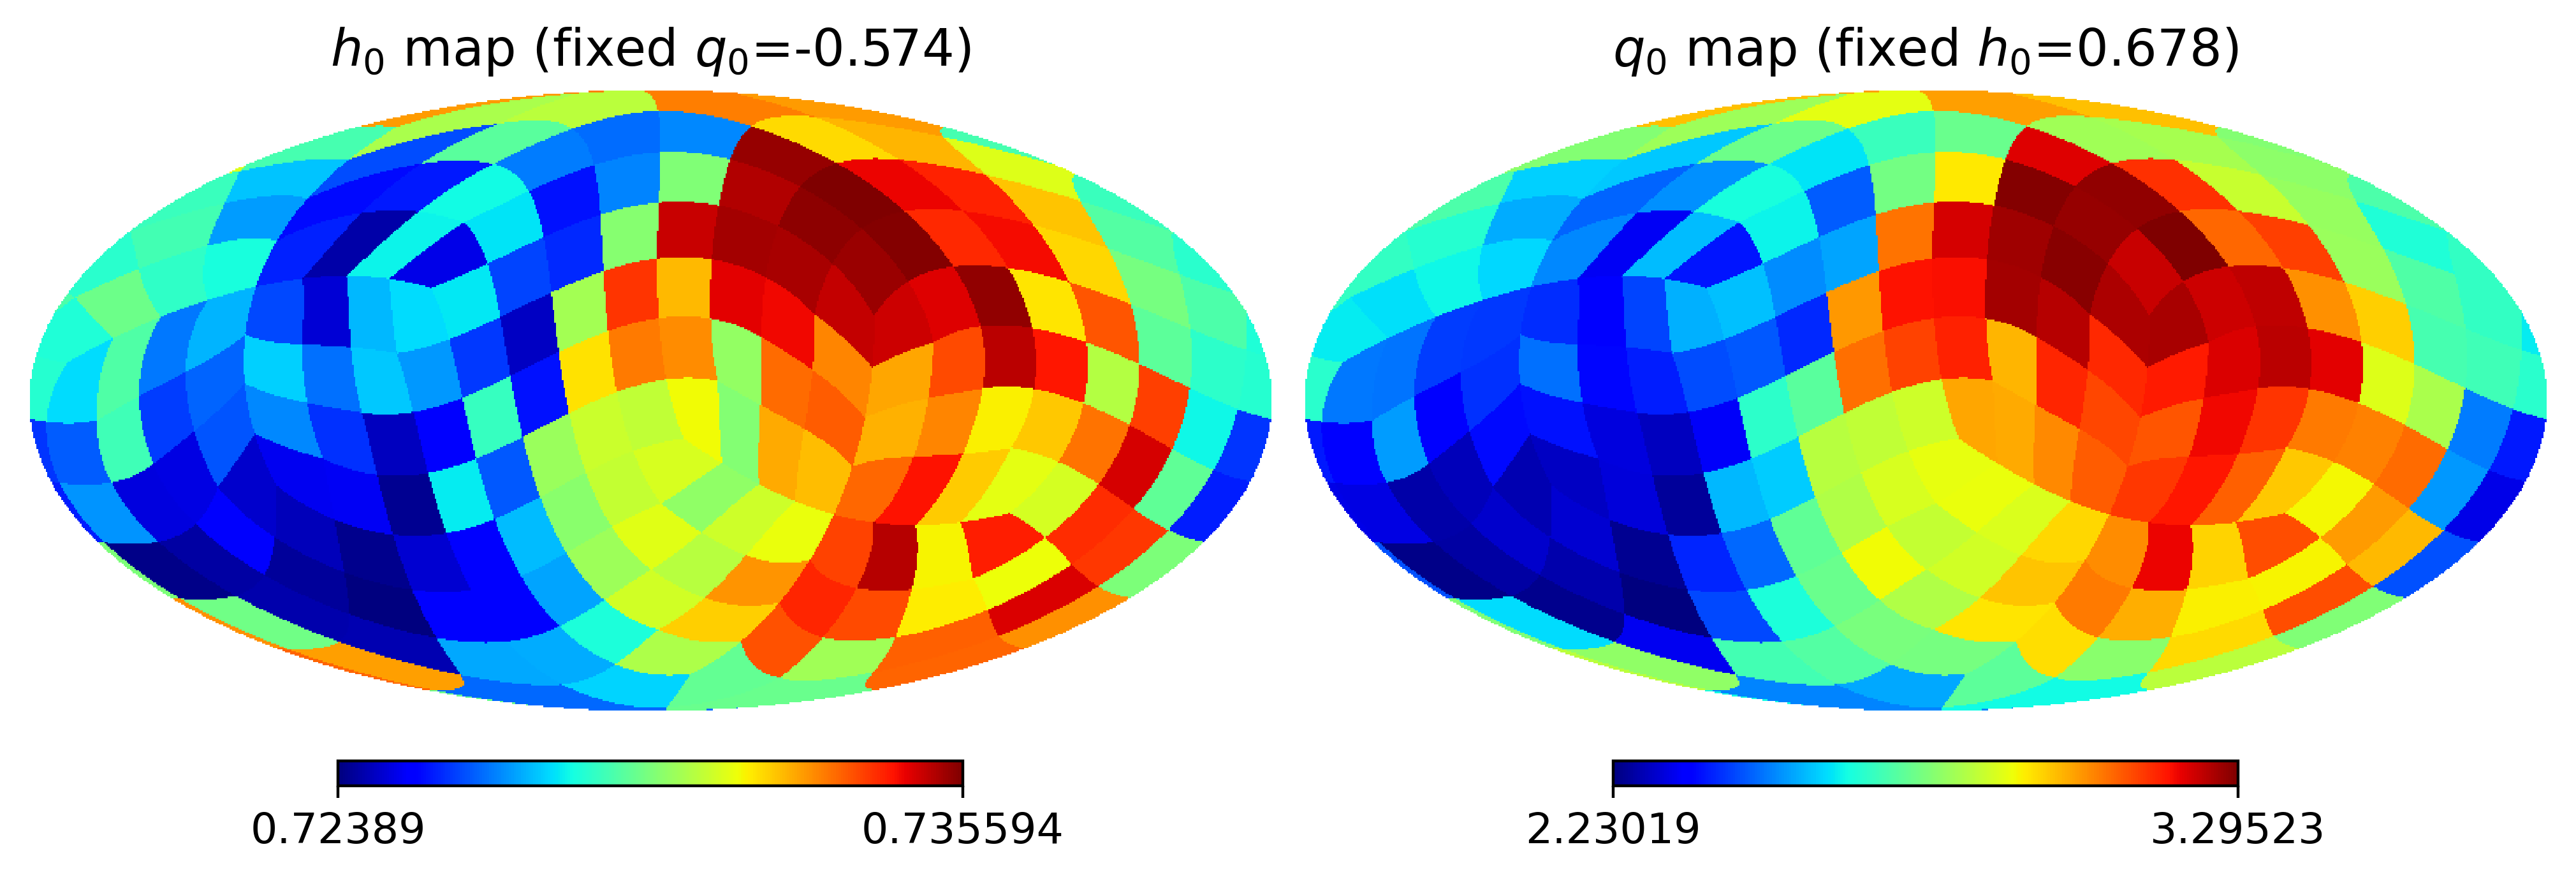

In [125]:
from generate_map import generate_map

# Maps are generated by the function generate_map which is defined in generate_map.py
h0map, q0map = generate_map(nside, theta, phi, h0, q0, h0f, q0f)

# Plot the generated maps side by side
plt.figure(figsize=(10, 3.7))

hp.mollview(h0map, coord="cg", title=rf'$h_0$ map (fixed $q_0$={q0f})', unit='', notext=True, norm='hist', cmap='jet',
            min=min(h0), max=max(h0), fig=1, sub=(1, 2, 1))
hp.mollview(q0map, coord="cg", title=rf'$q_0$ map (fixed $h_0$={h0f})', unit='', notext=True, norm='hist', cmap='jet',
            min=min(q0), max=max(q0), fig=1, sub=(1, 2, 2))

map_filename = f'figures/{prefix_name}[NO_SM](hf={h0f}_qf={q0f})({zup}>z>{zdown}).png'

plt.savefig(map_filename)
plt.show()

# Synthetic data implementation


### Uniform supernovae distribution

Below we have generated a random position vector for each supernova according to an uniform distribution. For more details refer to [Synthetic data on a sphere](<(1)synthetic_data.ipynb>).


In [126]:
# now we want to create this len(ra) vectors for each repetition of the simulation and store them in a list
repetitions = 3
# We store the new supernova positions (x,y,z) in v1_iso
v1_iso = np.zeros((repetitions, len(ra), 3))

for i in range(repetitions):
    vecti = np.random.randn(len(ra), 3)  # three random numbers vector (x,y,z)
    # normalize the vector
    vecti /= np.linalg.norm(vecti, axis=1)[:, np.newaxis]
    thetai = np.arccos(vecti[:, 2])  # arccos(z)
    phii = np.arctan2(vecti[:, 1], vecti[:, 0])  # arctan(y/x)
    deci = thetai  # declination
    rai = np.pi - phii  # right ascension
    v1i = np.column_stack(
        [np.sin(rai)*np.cos(deci), np.sin(rai)*np.sin(deci), np.cos(rai)])
    v1_iso[i] = v1i
v1_iso.shape

# v1_iso is a list of lenght 500 repetitions which contains 741 vectors (x,y,z) for each supernovae position (isotropic synthetic distribution)

(3, 741, 3)

#### Here we are going to run the 500 repetitions for the synthetic uniformly distributed data.


In [127]:
h0u_iso = []
h0d_iso = []
q0u_iso = []
q0d_iso = []

i = 1
for v1_it in v1_iso:
    clear_output()
    print('Repetition {}/{}'.format(i, repetitions))
    v1 = v1_it
    # Execute map with the given v1_iso element
    results_h0_iso_aux, results_q0_iso_aux = hem_comp_functions.exec_map(
        healpix_dirs, v1, r1, hostyn, cov_mat, h0f, q0f)

    h0u_iso.append(np.array(results_h0_iso_aux[0]))
    h0d_iso.append(np.array(results_h0_iso_aux[1]))
    q0u_iso.append(np.array(results_q0_iso_aux[0]))
    q0d_iso.append(np.array(results_q0_iso_aux[1]))
    i += 1

# Restore original v1 data as we are done.
v1 = np.column_stack(
    [np.sin(ra)*np.cos(dec), np.sin(ra)*np.sin(dec), np.cos(ra)])

Repetition 3/3


100%|██████████| 96/96 [00:00<00:00, 825108.98it/s]


In [128]:
# Convert all arrays to numpy arrays
h0u_iso = np.array(h0u_iso)
h0d_iso = np.array(h0d_iso)
q0u_iso = np.array(q0u_iso)
q0d_iso = np.array(q0d_iso)

In [129]:

h0m_iso = np.concatenate((h0u_iso, h0d_iso), axis=1)
q0m_iso = np.concatenate((q0u_iso, q0d_iso), axis=1)

# Find the maximum anisotropy for each repetition and store it
delta_h0_iso_max = np.max(h0m_iso, axis=1) - np.min(h0m_iso, axis=1)
delta_q0_iso_max = np.max(q0m_iso, axis=1) - np.min(q0m_iso, axis=1)

# Ploting the iterations

We want to adjust a Gaussian to the data and include lines which represent the original data maximum anisotropy and some fixed percentiles in the same plot as the histogram.

First, we fit a gaussian to the data. We do it using the function fit_gaussian in fit_gaussian.py


In [130]:

from fit_gaussian import fit_gaussian

# We need to import the fit_gaussian function from fit_gaussian.py. This function is in charge or generating the gaussian for our data.


# Fit a gaussian to the data using the fit_gaussian function. This function returns the x and y values of the gaussian.
x_gauss_h0_iso, y_gauss_h0_iso = fit_gaussian(delta_h0_iso_max)
x_gauss_q0_iso, y_gauss_q0_iso = fit_gaussian(delta_q0_iso_max)

### Plotting the data


In [ ]:
data_h0_iso_hist = [delta_h0_iso_max,
                    delta_h0_data_max, x_gauss_h0_iso, y_gauss_h0_iso]
data_q0_iso_hist = [delta_q0_iso_max,
                    delta_q0_data_max, x_gauss_q0_iso, y_gauss_q0_iso]

file_name_iso = f'{prefix_name}[ISO](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'

plot_histograms(data_h0_iso_hist, data_q0_iso_hist, titlemarker='ISO')

## Synthetic distance modulus (sampled from a normal distribution)

### We are going to create a normal distribution with mean $\mu_{fid}$ and $\sigma$ will be the original error on the distance modulus.

For more details on synthetic data, refer to [Synthethic data for distance modulus](synthetic_data.ipynb).


In [155]:
repetitions = 3

mu_fid = np.array([mu(z, h0f, q0f) for z in zz])  # 1D array 741
# 3D array (repetitions, 741, 7) this is the grid of repetitions of r1 which will be modified to include the new mu_sample values.
r1_lcdm = np.tile(r1, (repetitions, 1, 1))

for i in range(repetitions):
    mu_sample = np.random.normal(mu_fid, sigmuz)
    r1_lcdm[i, :, 5] = mu_sample

For each repetition we sample a new distance modulus for each supernovae from the normal distribution $N(\mu_{fid}, sigmuz)$

Where sigmuz is the original error on the distance modulus and $\mu_{fid}$ is the fiducial value for the distance modulus.

#### we call the function using he map method from pool object as follows:


In [ ]:
hem_comp_functions.exec_map(
    healpix_dirs, v1_iso[0], r1, hostyn, cov_mat, h0f, q0f)

In [156]:
hem_comp_functions.exec_map(
    healpix_dirs, v1, r1_lcdm[0], hostyn, cov_mat, h0f, q0f)

/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.log10(dl(z, h0, q0)) + 25.0
/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.log10(dl(z, h0, q0)) + 25.0
/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.log10(dl(z, h0, q0)) + 25.0
/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.log10(dl(z, h0, q0)) + 25.0
/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.log10(dl(z, h0, q0)) + 25.0
/home/diego/Documentos/universidad/cosmographic_analysis/cosmology.py:28: RuntimeWarning: invalid value encountered in log10
  return 5.0 * np.lo

KeyboardInterrupt: 

In [ ]:
import hem_comp_functions

h0um_lcdm = []
h0dm_lcdm = []
q0um_lcdm = []
q0dm_lcdm = []

i = 1
for r1_it in r1_lcdm:
    clear_output()
    print('Repetition {}/{}'.format(i, repetitions))
    # r1 = r1_it
    results_h0_lcdm_aux, results_q0_lcdm_aux = hem_comp_functions.exec_map(
        healpix_dirs, v1, r1_it, hostyn, cov_mat, h0f, q0f)

    h0um_lcdm.append(np.array(results_h0_lcdm_aux[0]))
    h0dm_lcdm.append(np.array(results_h0_lcdm_aux[1]))
    q0um_lcdm.append(np.array(results_q0_lcdm_aux[0]))
    q0dm_lcdm.append(np.array(results_q0_lcdm_aux[1]))
    i += 1

# Restore original r1 data

r1 = np.column_stack([ra, dec, zz, mz, sigmz, muz, sigmuz, muceph, hostyn])

In [59]:
h0um_lcdm = np.array(h0um_lcdm)
h0dm_lcdm = np.array(h0dm_lcdm)
q0um_lcdm = np.array(q0um_lcdm)
q0dm_lcdm = np.array(q0dm_lcdm)

In [60]:
h0m_lcdm = np.concatenate((h0um_lcdm, h0dm_lcdm), axis=1)
q0m_lcdm = np.concatenate((q0um_lcdm, q0dm_lcdm), axis=1)

delta_h0_lcdm_max = np.max(h0m_lcdm, axis=1) - np.min(h0m_lcdm, axis=1)
delta_q0_lcdm_max = np.max(q0m_lcdm, axis=1) - np.min(q0m_lcdm, axis=1)

In [ ]:

from fit_gaussian import fit_gaussian

# We need to import the fit_gaussian function from fit_gaussian.py. This function is in charge or generating the gaussian for our data.


# Fit a gaussian to the data using the fit_gaussian function. This function returns the x and y values of the gaussian.
x_gauss_h0_lcdm, y_gauss_h0_lcdm = fit_gaussian(delta_h0_lcdm_max)
x_gauss_q0_lcdm, y_gauss_q0_lcdm = fit_gaussian(delta_q0_lcdm_max)

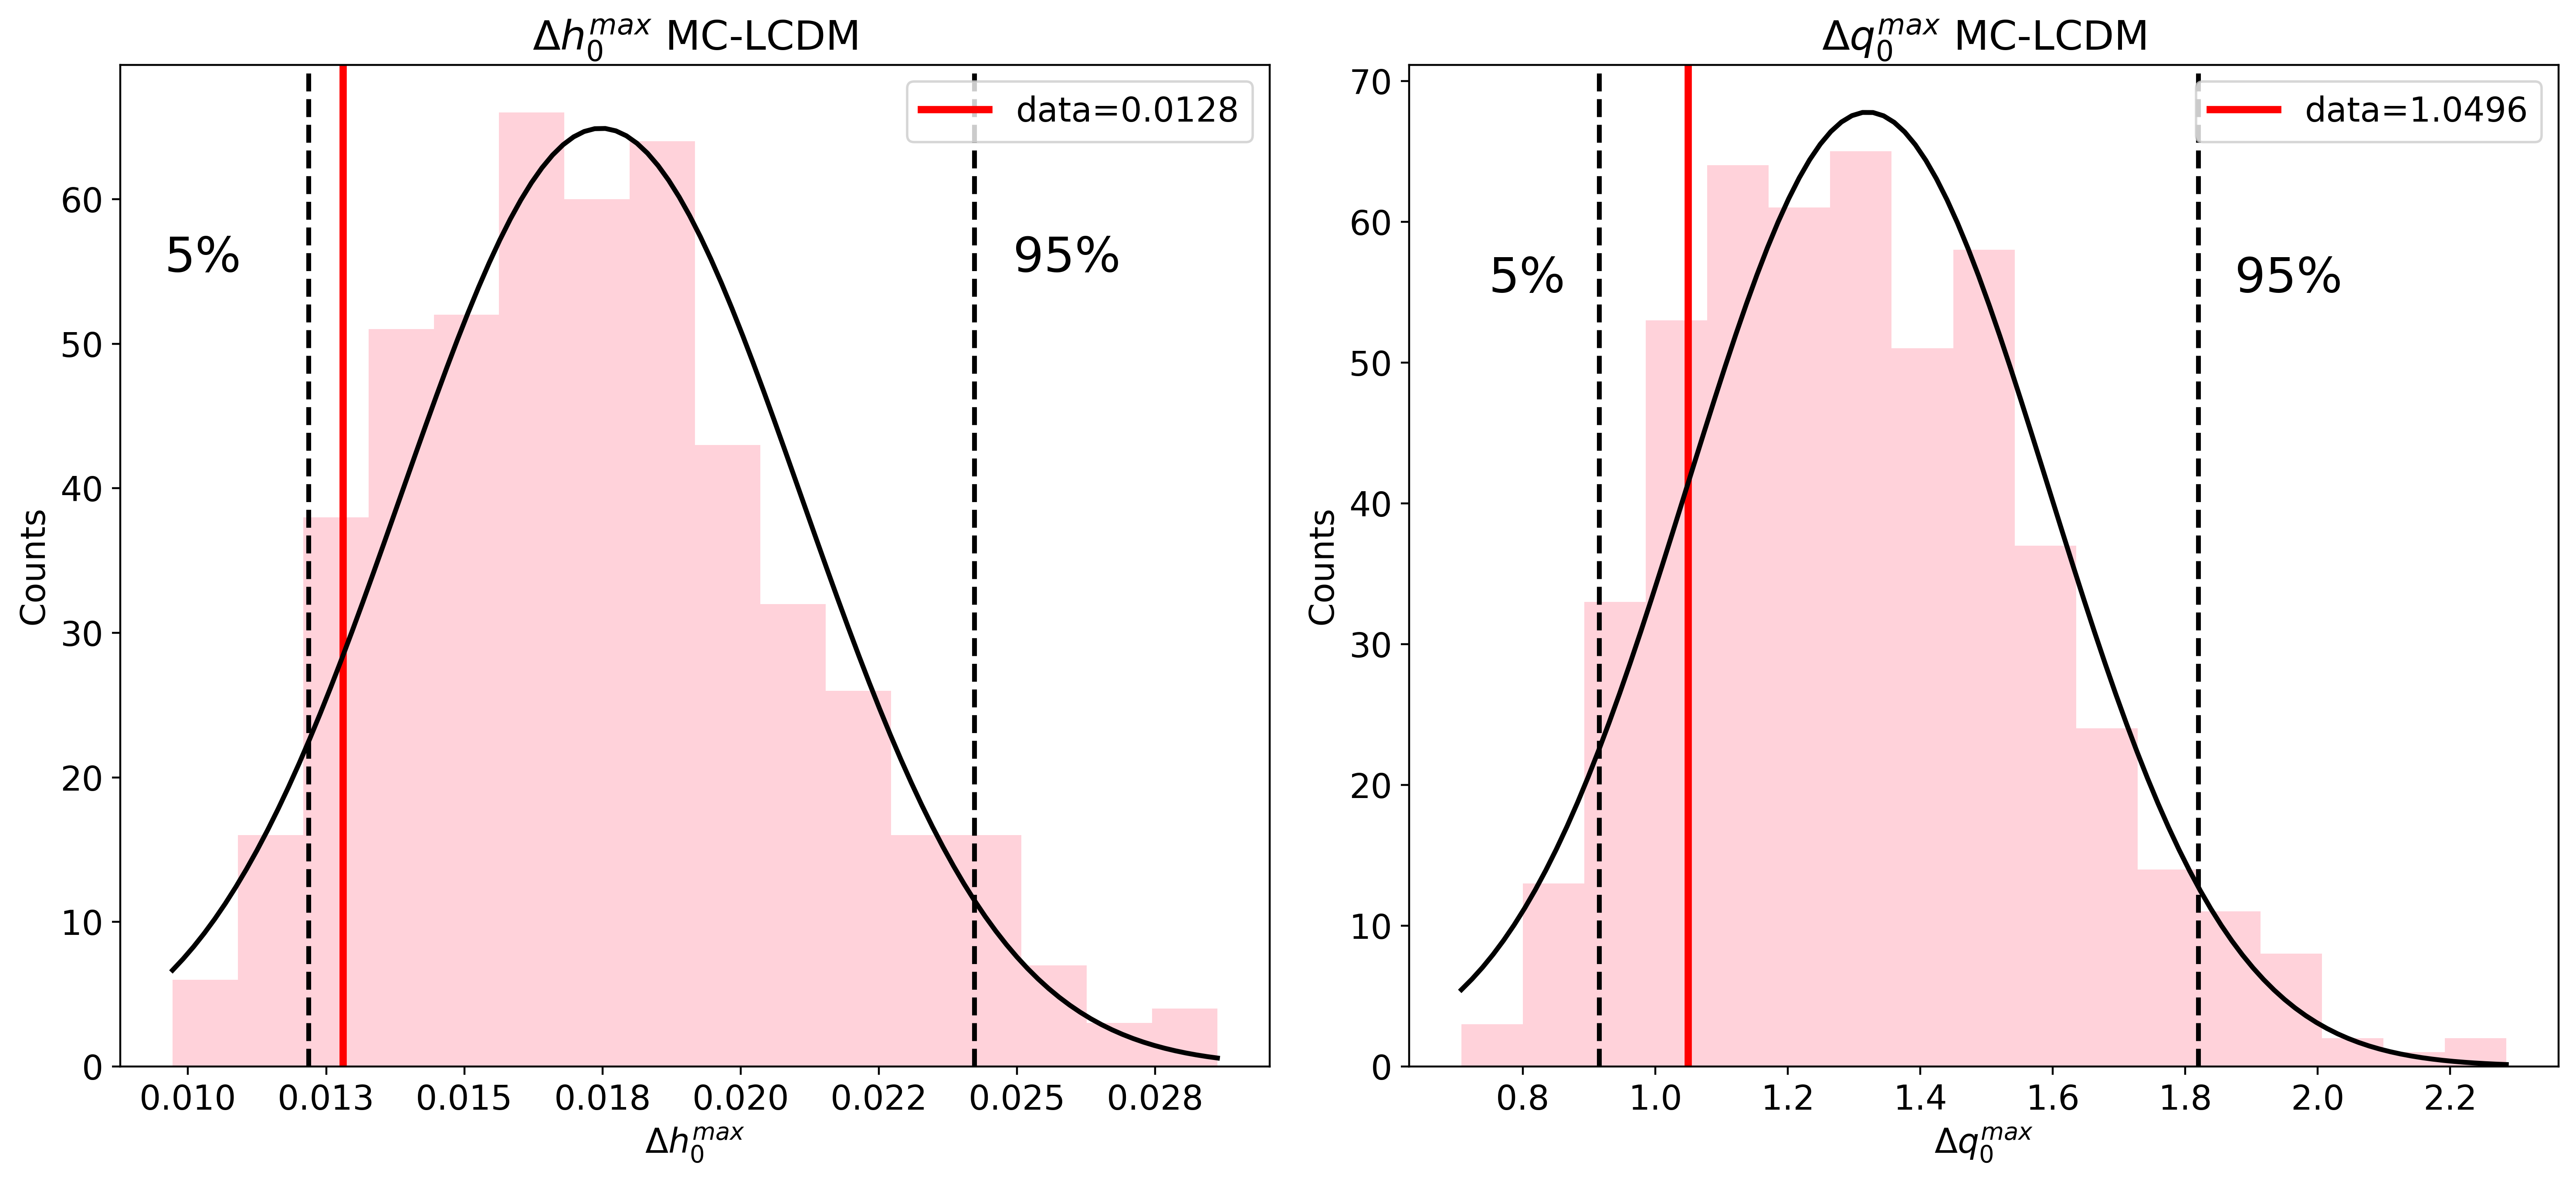

In [ ]:
from generate_histograms import plot_histograms

data_h0_lcdm_hist = [delta_h0_lcdm_max,
                     delta_h0_data_max, x_gauss_h0_lcdm, y_gauss_h0_lcdm]
data_q0_lcdm_hist = [delta_q0_lcdm_max,
                     delta_q0_data_max, x_gauss_q0_lcdm, y_gauss_q0_lcdm]


file_name_lcdm = f'{prefix_name}[ISO](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'

plot_histograms(data_h0_lcdm_hist, data_q0_lcdm_hist, titlemarker='LCDM')

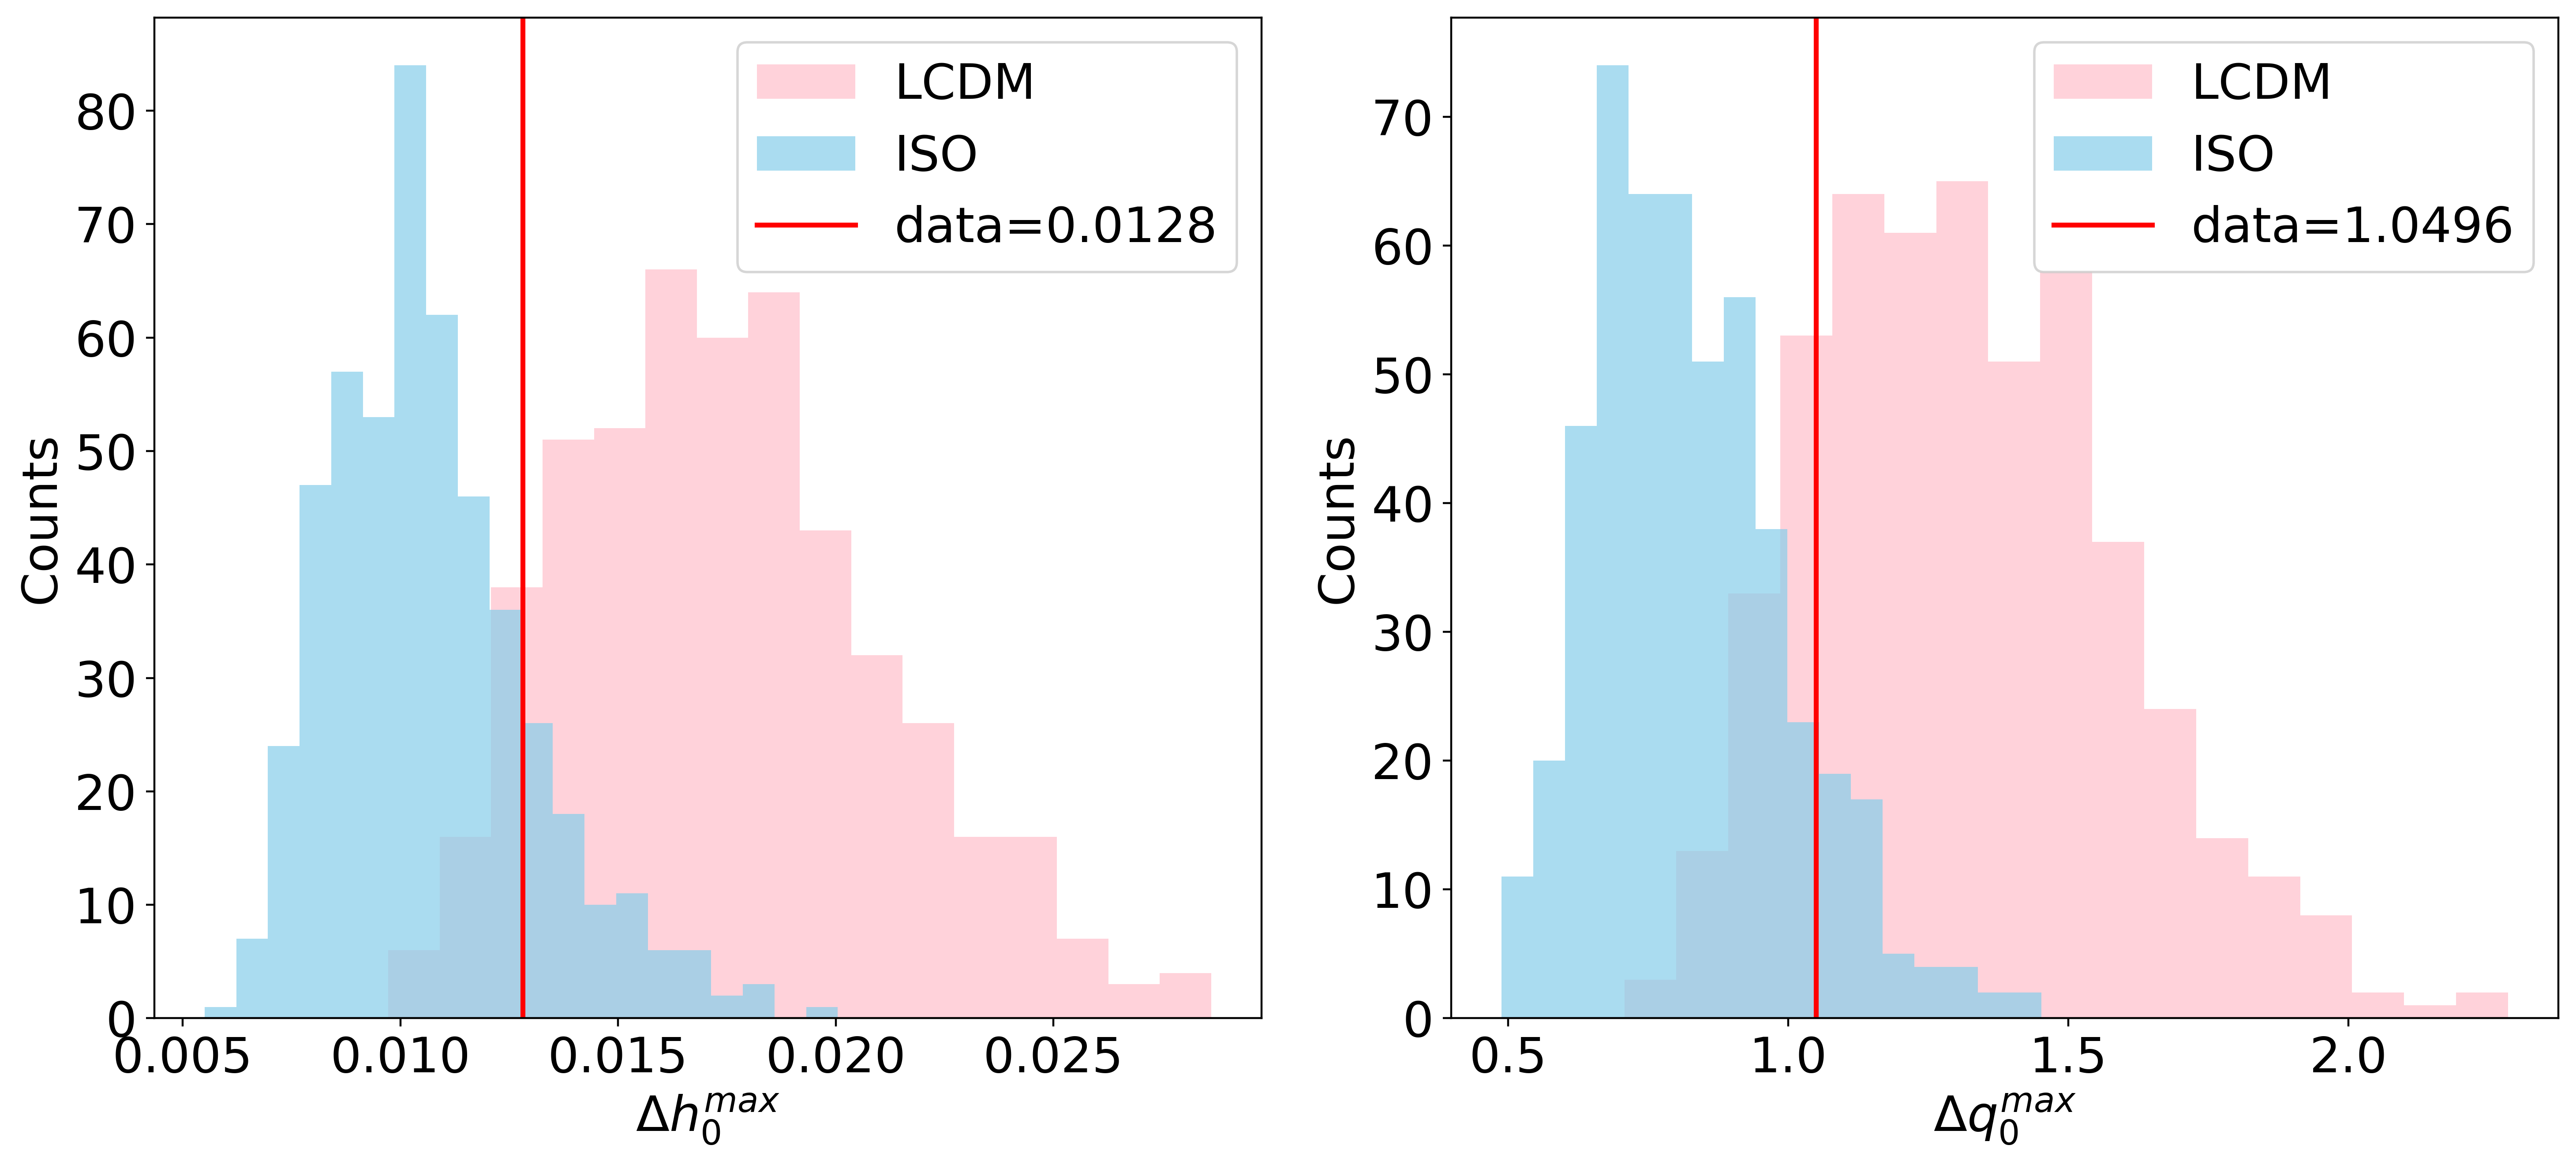

In [255]:
# plot both histrograms for LCDM and ISO in the same plot using the plot_both_histograms function
from generate_histograms import plot_both_histograms

data_h0 = [delta_h0_iso_max, delta_h0_lcdm_max, delta_h0_data_max]
data_q0 = [delta_q0_iso_max, delta_q0_lcdm_max, delta_q0_data_max]

file_name_both = f'{prefix_name}[BOTH](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'

plot_both_histograms(data_h0, data_q0, filename=file_name_both)

# Saving the results in text files


### Save ISO


In [ ]:
header_iso = f'This is the data for ISO distribution with new set of data for each repetition\n{repetitions} repetitions, {pts} points q0f= {q0f} h0f= {h0f}\n\ndelta_h0_iso_max           delta_q0_iso_max'

filename_iso = f'compilations/{prefix_name}[ISO]({h0f}=h0f_{q0f}=q0f)({repetitions}_rep)({pts}_pts)({zup}>z>{zdown}).txt'

save_data_iso = np.column_stack([delta_h0_iso_max, delta_q0_iso_max])

np.savetxt(filename_iso, save_data_iso, header=header_iso)

### Save LCDM


In [ ]:
header_lcdm = f'[SH0ES_CALIB][HEALPIX] This is the data for LCDM distribution with a new set of data for each repetition\n{repetitions} repetitions, {pts} points, q0f= {q0f} h0f= {h0f}\n\ndelta_h0_lcdm_max            delta_q0_lcdm_max'

filename_lcdm = f'compilations/{prefix_name}[LCDM]({h0f}=h0f_{q0f}=q0f)({repetitions}_rep)({pts}_pts)({zup}>z>{zdown}).txt'

save_data_lcdm = np.column_stack([delta_h0_lcdm_max, delta_q0_lcdm_max])

np.savetxt(filename_lcdm, save_data_lcdm, header=header_lcdm)

# Load the results from text files


In [102]:
file_path_iso = 'compilations/[SH0ES_CALIB][HEALPIX][ISO](0.678=h0f_-0.574=q0f)(500_rep)(1536_pts)(0.1>z>0.0).txt'

# file_path_iso = 'compilations/[SH0ES_CALIB][HEALPIX][ISO](0.7304=h0f_-0.574=q0f)(500_rep)(1536_pts)(0.1>z>0.0).txt'


data_iso = np.loadtxt(file_path_iso, usecols=(0, 1), skiprows=4)

delta_h0_iso_max = data_iso[:, 0]
delta_q0_iso_max = data_iso[:, 1]

In [103]:
file_path_lcdm = 'compilations/[SH0ES_CALIB][HEALPIX][LCDM](0.678=h0f_-0.574=q0f)(500_rep)(1536_pts)(0.1>z>0.0).txt'

# file_path_lcdm = 'compilations/[SH0ES_CALIB][HEALPIX][LCDM](0.7304=h0f_-0.574=q0f)(500_rep)(3072_pts)(0.1>z>0.0).txt'

data_lcdm = np.loadtxt(file_path_lcdm, usecols=(0, 1), skiprows=4)

delta_h0_lcdm_max = data_lcdm[:, 0]
delta_q0_lcdm_max = data_lcdm[:, 1]

In [104]:
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 20

In [105]:
# We need to import the fit_gaussian function from fit_gaussian.py. This function is in charge or generating the gaussian for our data.
from fit_gaussian import fit_gaussian


# Fit a gaussian to the data using the fit_gaussian function. This function returns the x and y values of the gaussian to be plotted.
x_gauss_h0_iso, y_gauss_h0_iso = fit_gaussian(delta_h0_iso_max)
x_gauss_q0_iso, y_gauss_q0_iso = fit_gaussian(delta_q0_iso_max)

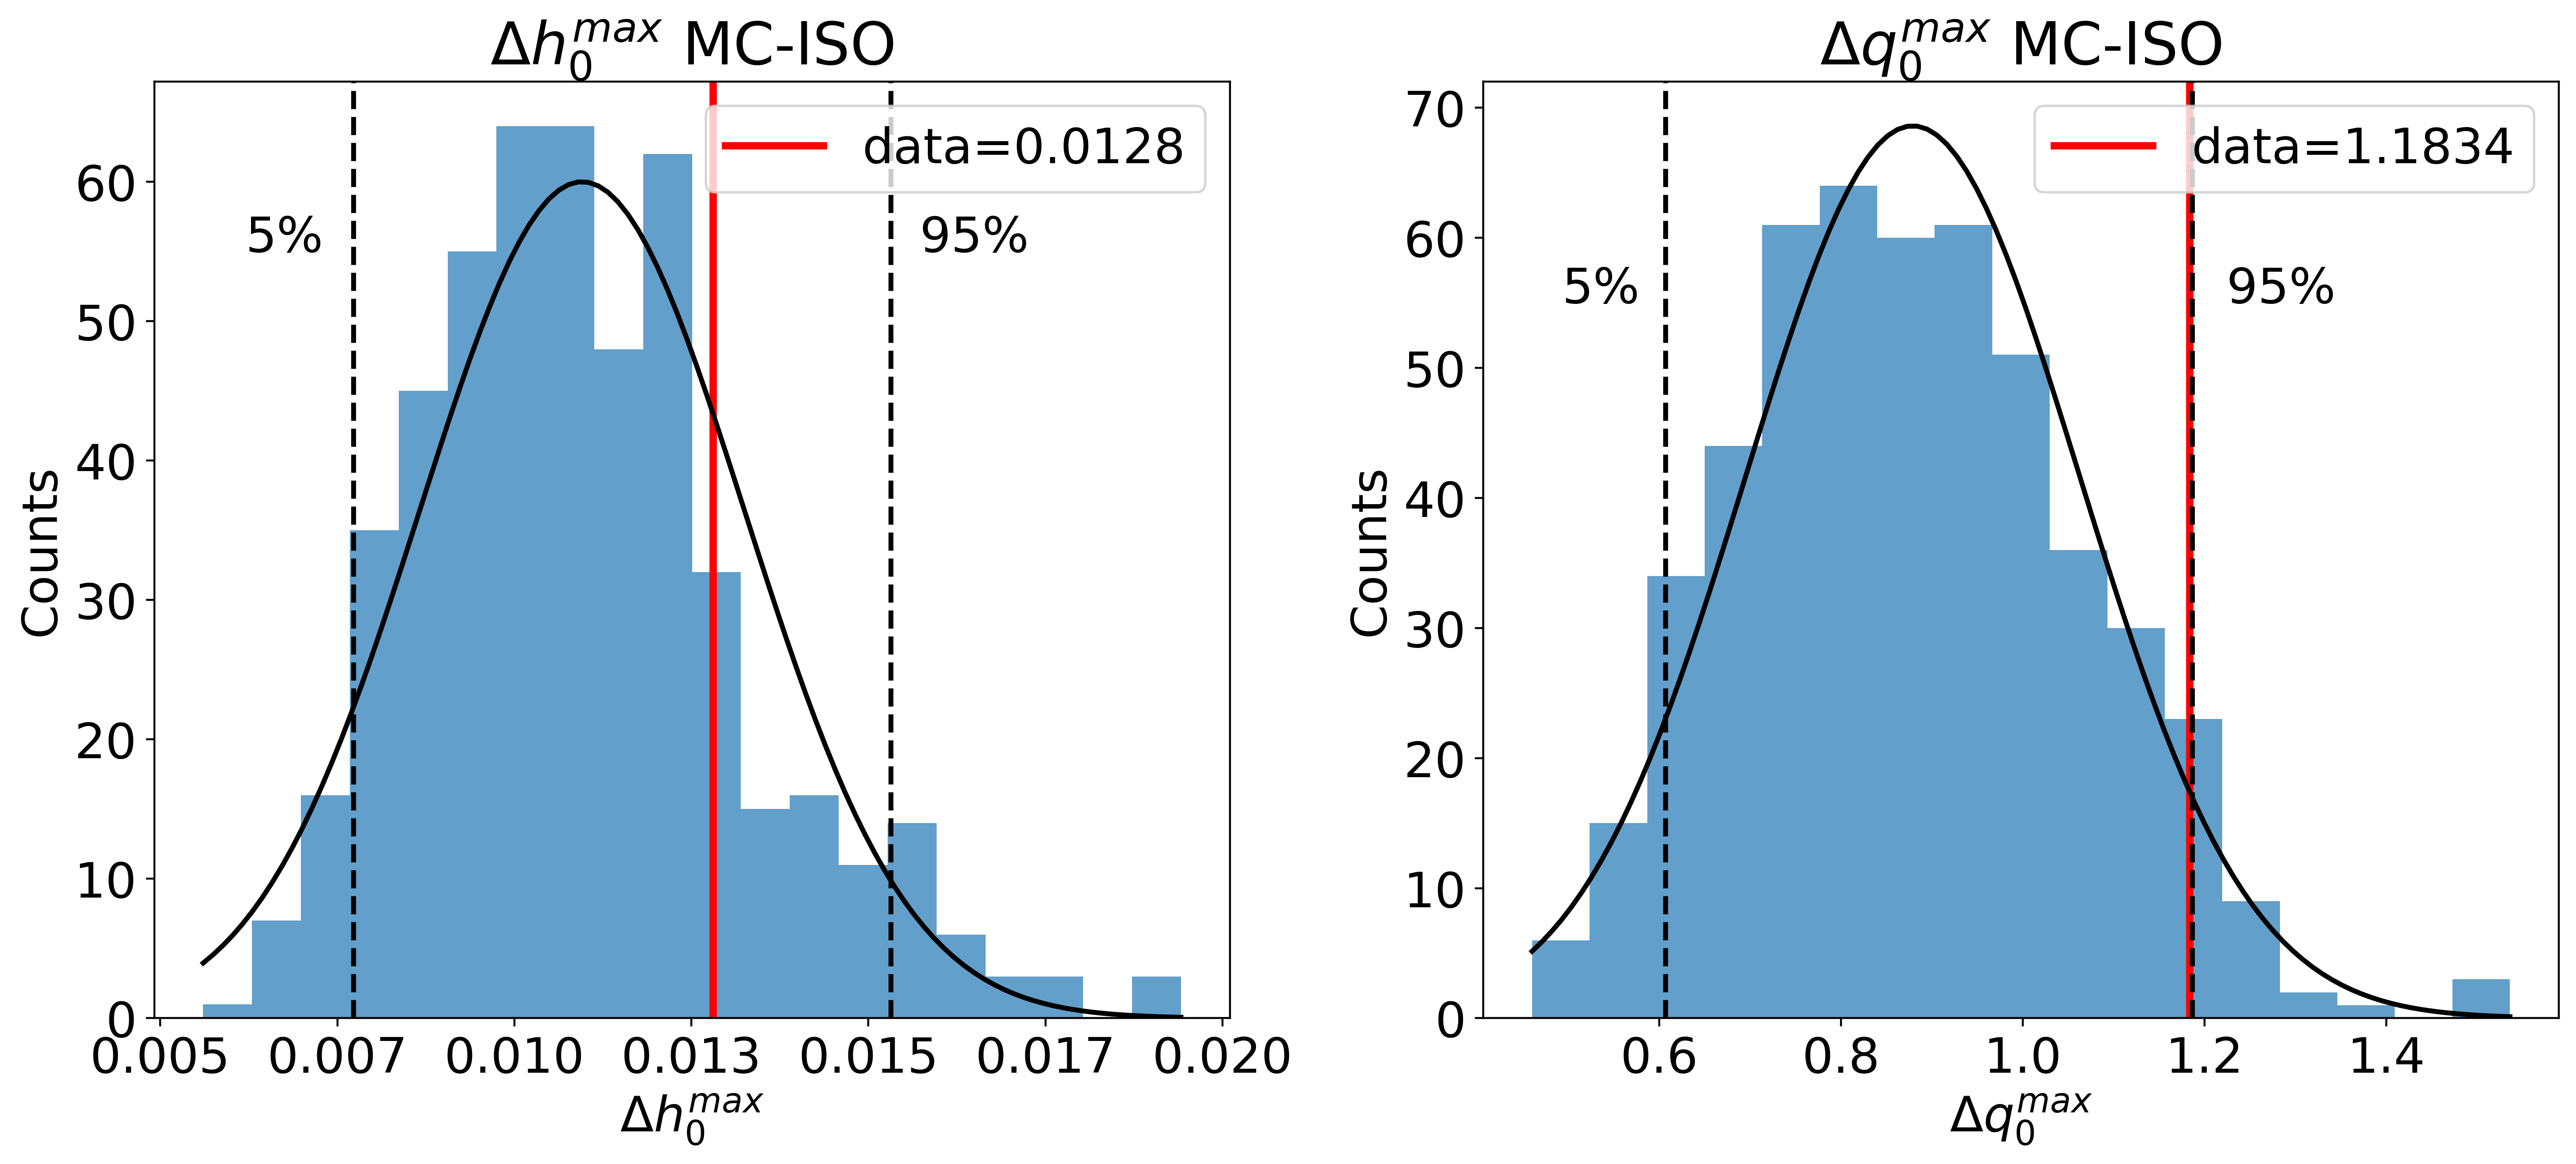

In [106]:
from generate_histograms import plot_histograms

data_h0_iso_hist = [delta_h0_iso_max,
                    delta_h0_data_max, x_gauss_h0_iso, y_gauss_h0_iso]
data_q0_iso_hist = [delta_q0_iso_max,
                    delta_q0_data_max, x_gauss_q0_iso, y_gauss_q0_iso]

file_name_iso = f'{prefix_name}[ISO](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'


plot_histograms(data_h0_iso_hist, data_q0_iso_hist, filename=file_name_iso)

In [107]:
x_gauss_h0_lcdm, y_gauss_h0_lcdm = fit_gaussian(delta_h0_lcdm_max)
x_gauss_q0_lcdm, y_gauss_q0_lcdm = fit_gaussian(delta_q0_lcdm_max)

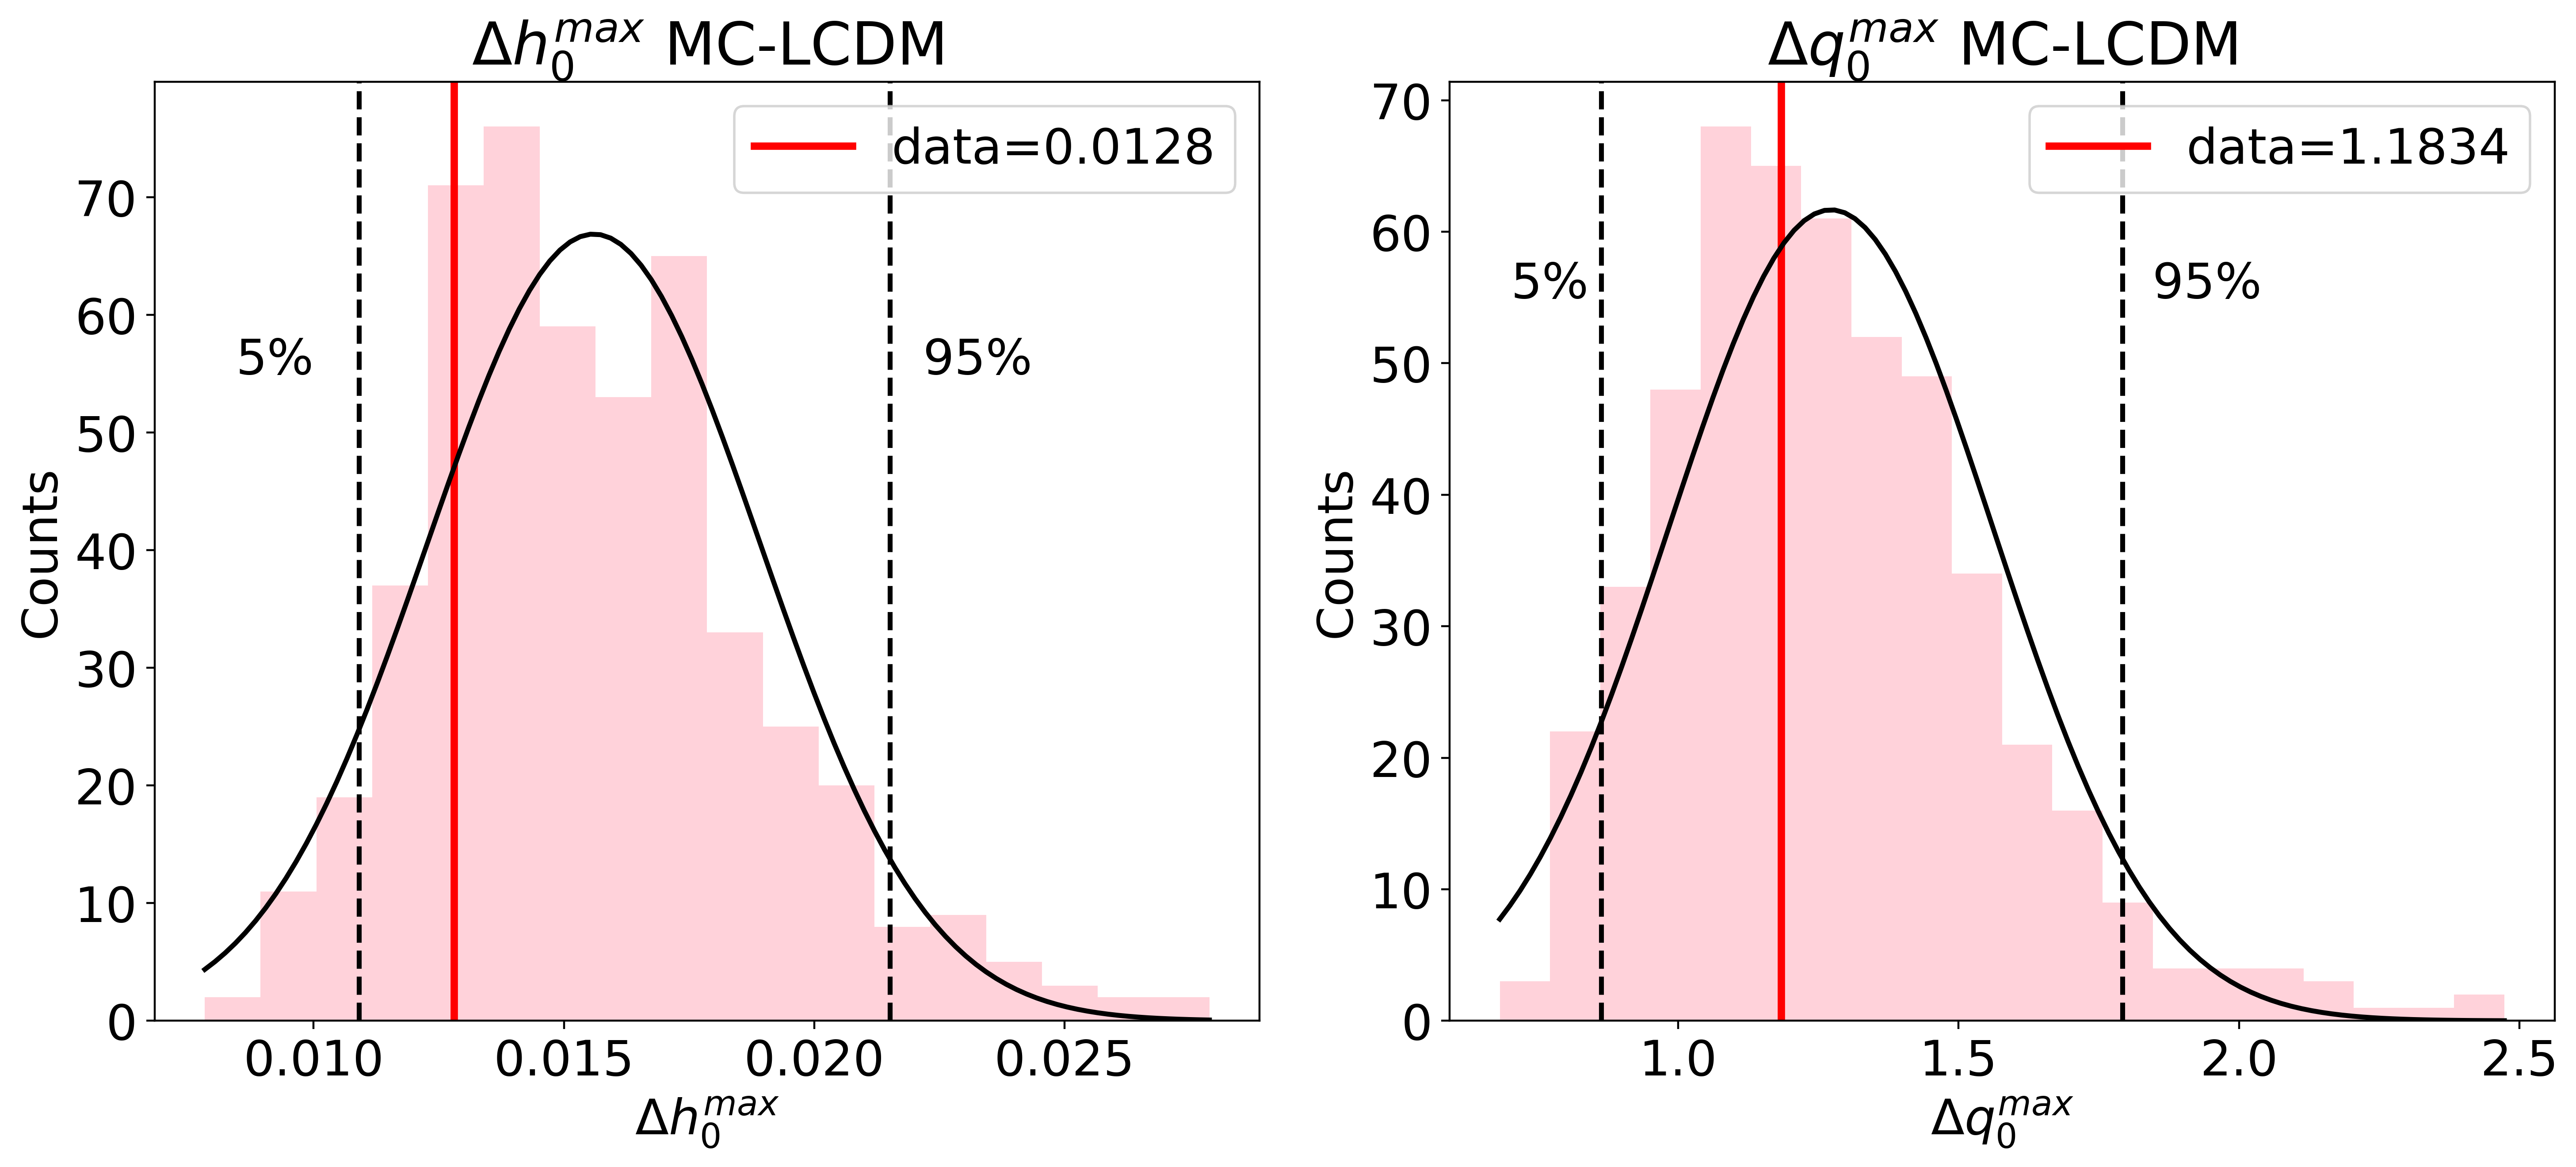

In [108]:
from generate_histograms import plot_histograms

data_h0_lcdm_hist = [delta_h0_lcdm_max,
                     delta_h0_data_max, x_gauss_h0_lcdm, y_gauss_h0_lcdm]
data_q0_lcdm_hist = [delta_q0_lcdm_max,
                     delta_q0_data_max, x_gauss_q0_lcdm, y_gauss_q0_lcdm]


file_name_lcdm = f'{prefix_name}[LCDM](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'

plot_histograms(data_h0_lcdm_hist, data_q0_lcdm_hist,
                titlemarker='LCDM', filename=file_name_lcdm)

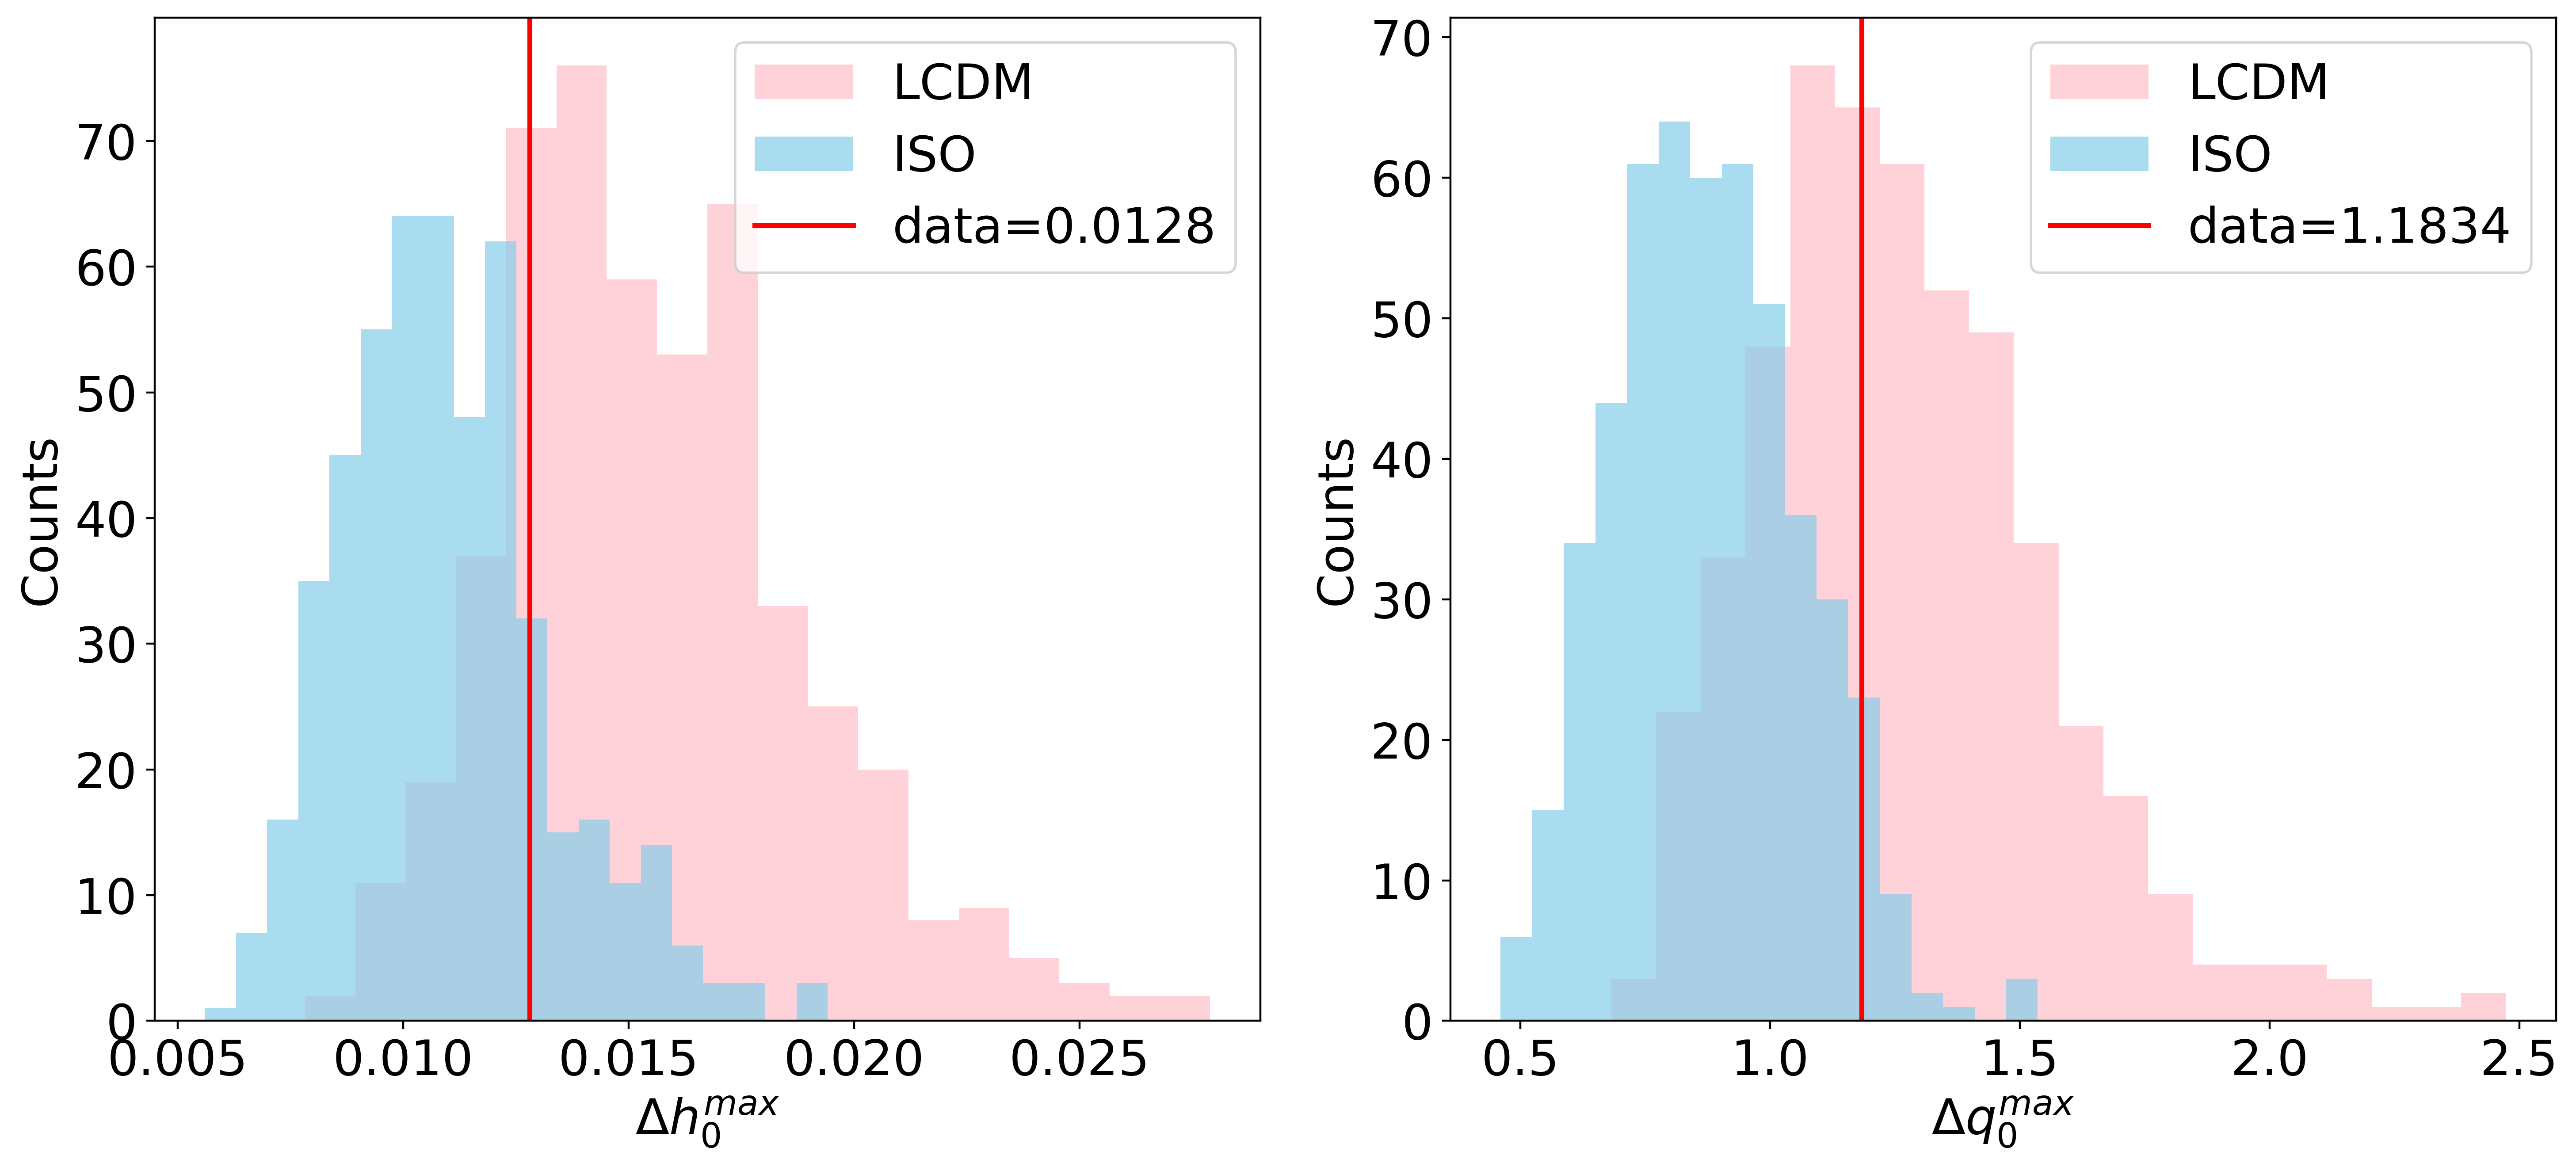

In [109]:
# plot both histrograms for LCDM and ISO in the same plot using the plot_both_histograms function
from generate_histograms import plot_both_histograms

data_h0 = [delta_h0_iso_max, delta_h0_lcdm_max, delta_h0_data_max]
data_q0 = [delta_q0_iso_max, delta_q0_lcdm_max, delta_q0_data_max]

file_name_both = f'{prefix_name}[BOTH](hf={h0f}_qf={q0f})({repetitions})_rep_({zup}>z>{zdown}).png'

plot_both_histograms(data_h0, data_q0, filename=file_name_both)

# Some statistics


In [31]:
import get_statistics

# This function takes all maximum anisotropy for each LCDM and ISO and returns the pvalues

maximum_anisotropy_data = [delta_h0_data_max, delta_q0_data_max]
maximum_anisotropy_mc = [delta_h0_lcdm_max,
                         delta_q0_lcdm_max, delta_h0_iso_max, delta_q0_iso_max]

p_values = get_statistics.mc_statistics(
    maximum_anisotropy_data, maximum_anisotropy_mc)

p_h0_iso_max = p_values[0]
p_q0_iso_max = p_values[1]
p_h0_lcdm_max = p_values[2]
p_q0_lcdm_max = p_values[3]

Porcentaje de repeticiones que dan delta_h0 mayor a los datos (ISO) = 16.2
Porcentaje de repeticiones que dan delta_q0 mayor a los datos (ISO) = 10.8

Porcentaje de repeticiones que dan delta_h0 mayor a los datos (LCDM) = 83.2
Porcentaje de repeticiones que dan delta_q0 mayor a los datos (LCDM) = 76.4

La media de delta_h0_max (ISO) es = 0.010683781511950593
La media de delta_q0_max (ISO) es = 0.8248447794644614

La media de delta_h0_max (LCDM) es = 0.016613994140624967
La media de delta_q0_max (LCDM) es = 1.266682226562502

La desviación estándar de delta_h0_max (ISO) es = 0.0022968619189143377
La desviación estándar de delta_q0_max (ISO) es = 0.1726959590475971

La desviación estándar de delta_h0_max (LCDM) es = 0.003915929656979449
La desviación estándar de delta_q0_max (LCDM) es = 0.2834068421346859


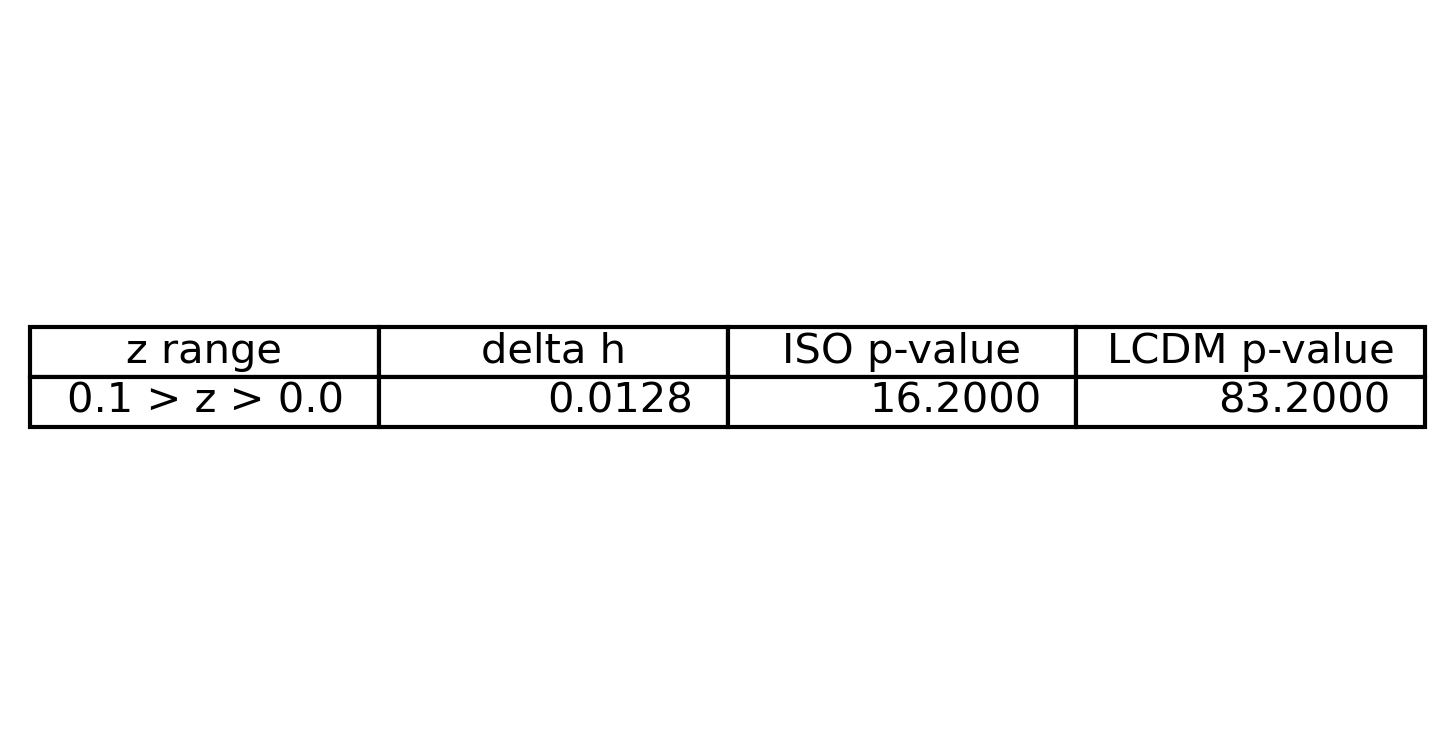

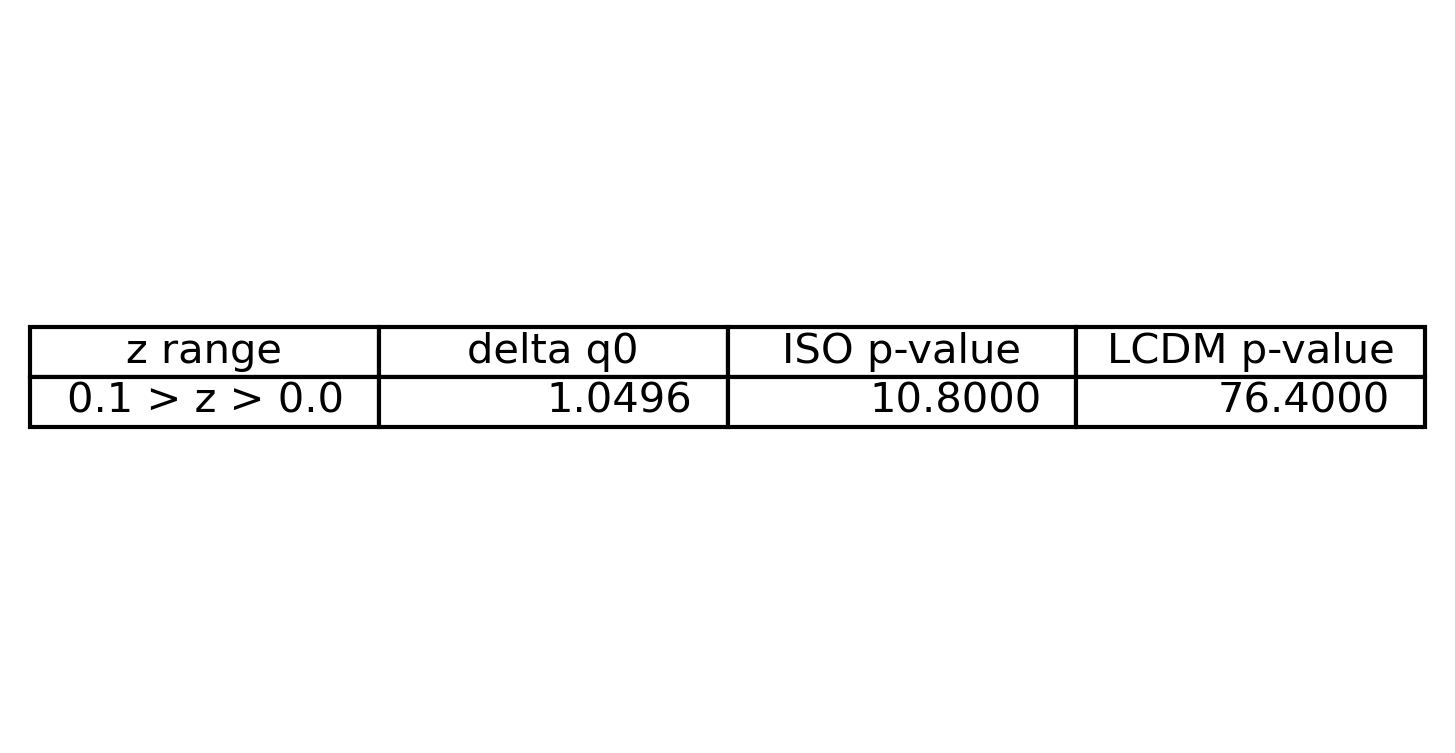

In [30]:
rcParams['figure.dpi'] = 300
z_ranges = [f"{zup} > z > {zdown}"]

delta_h = [f"{delta_h0_data_max:.4f}"]
iso_pvalues = [f"{p_h0_iso_max:.4f}"]
lcdm_pvalues = [f"{p_h0_lcdm_max:.4f}"]

delta_q0 = [f"{delta_q0_data_max:.4f}"]
iso_q0_pvalues = [f"{p_q0_iso_max:.4f}"]
lcdm_q0_pvalues = [f"{p_q0_lcdm_max:.4f}"]

# Crear el DataFrame para el mapa de Hubble
df_hubble = pd.DataFrame({"z range": z_ranges, "delta h": delta_h,
                         "ISO p-value": iso_pvalues, "LCDM p-value": lcdm_pvalues})

# Crear el DataFrame para los valores de q0
df_q0 = pd.DataFrame({"z range": z_ranges, "delta q0": delta_q0,
                     "ISO p-value": iso_q0_pvalues, "LCDM p-value": lcdm_q0_pvalues})

# Crear la figura y el eje para la tabla del mapa de Hubble
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_hubble.values, colLabels=df_hubble.columns, loc='center')

# Guardar la tabla del mapa de Hubble en un archivo PNG
plt.savefig(
    f'tables/{prefix_name}[h0_table](hf={h0f}_qf={q0f})_({zup}>z>{zdown})({pts}_pts)_({len(delta_h0_iso_max)})_rep_.png')

# Crear la figura y el eje para la tabla de q0
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df_q0.values, colLabels=df_q0.columns, loc='center')

# Guardar la tabla de q0 en un archivo PNG
plt.savefig(
    f'tables/{prefix_name}[q0_table](hf={h0f}_qf={q0f})_({zup}>z>{zdown})({pts}_pts)_({len(delta_h0_iso_max)})_rep_.png')